In [106]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from utils import read_log
from math import log, sqrt
from statistics import NormalDist

In [243]:
class BlackScholes:
    def __init__(self, spot, strike, time_to_expiry):
        self.spot = spot
        self.strike = strike
        self.time_to_expiry = time_to_expiry

    def call_price(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        d2 = d1 - volatility * sqrt(self.time_to_expiry)
        call_price = self.spot * NormalDist().cdf(d1) - self.strike * NormalDist().cdf(d2)
        return call_price

    def delta(self, volatility):
        d1 = (
            log(self.spot) - log(self.strike) + (0.5 * volatility * volatility) * self.time_to_expiry
        ) / (volatility * sqrt(self.time_to_expiry))
        return NormalDist().cdf(d1)

    def implied_volatility(self, market_call_price, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = self.call_price(volatility)
            diff = estimated_price - market_call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [244]:
def calc_theoretical_price(x):
    tte = 5 / 250 - (x['timestamp'] + x['day'] * 1_000_000) / 1_000_000 / 250
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.call_price(x['realized_vol'])

In [245]:
def calc_implied_vol(x):
    tte = 5 / 250 - (x['timestamp'] + x['day'] * 1_000_000) / 1_000_000 / 250
    bs = BlackScholes(spot=x['spot'], strike=x['strike'], time_to_expiry=tte)
    return bs.implied_volatility(x['mid_price'])

# Round 3

In [109]:
price_0 = pd.read_csv('../data/raw/round_3/prices_round_3_day_0.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_3/prices_round_3_day_1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')

In [110]:
trades_0 = pd.read_csv('../data/raw/round_3/trades_round_3_day_0.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_3/trades_round_3_day_1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_3/trades_round_3_day_2.csv', delimiter=';')

In [111]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [258]:
rock = prices[prices['product'] == 'VOLCANIC_ROCK'].reset_index(drop=True)
call_0 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'].reset_index(drop=True)
call_1 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'].reset_index(drop=True)
call_2 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'].reset_index(drop=True)
call_3 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'].reset_index(drop=True)
call_4 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].reset_index(drop=True)

call_0 = call_0.assign(spot=rock['mid_price'])
call_1 = call_1.assign(spot=rock['mid_price'])
call_2 = call_2.assign(spot=rock['mid_price'])
call_3 = call_3.assign(spot=rock['mid_price'])
call_4 = call_4.assign(spot=rock['mid_price'])

call_0 = call_0.assign(strike=9500)
call_1 = call_1.assign(strike=9750)
call_2 = call_2.assign(strike=10000)
call_3 = call_3.assign(strike=10250)
call_4 = call_4.assign(strike=10500)

call_0['implied_vol'] = call_0.apply(calc_implied_vol, axis=1)
call_1['implied_vol'] = call_1.apply(calc_implied_vol, axis=1)
call_2['implied_vol'] = call_2.apply(calc_implied_vol, axis=1)
call_3['implied_vol'] = call_3.apply(calc_implied_vol, axis=1)
call_4['implied_vol'] = call_4.apply(calc_implied_vol, axis=1)

call_0 = call_0.assign(realized_vol=lambda x: np.log(x['mid_price'] / x['mid_price'].shift(1)).rolling(5).std() +  + 0.00001)
call_1 = call_1.assign(realized_vol=lambda x: np.log(x['mid_price'] / x['mid_price'].shift(1)).rolling(5).std() +  + 0.00001)
call_2 = call_2.assign(realized_vol=lambda x: np.log(x['mid_price'] / x['mid_price'].shift(1)).rolling(5).std() +  + 0.00001)
call_3 = call_3.assign(realized_vol=lambda x: np.log(x['mid_price'] / x['mid_price'].shift(1)).rolling(5).std() +  + 0.00001)
call_4 = call_4.assign(realized_vol=lambda x: np.log(x['mid_price'] / x['mid_price'].shift(1)).rolling(5).std() +  + 0.00001)

call_0['fair_value'] = call_0.apply(calc_theoretical_price, axis=1)
call_1['fair_value'] = call_1.apply(calc_theoretical_price, axis=1)
call_2['fair_value'] = call_2.apply(calc_theoretical_price, axis=1)
call_3['fair_value'] = call_3.apply(calc_theoretical_price, axis=1)
call_4['fair_value'] = call_4.apply(calc_theoretical_price, axis=1)

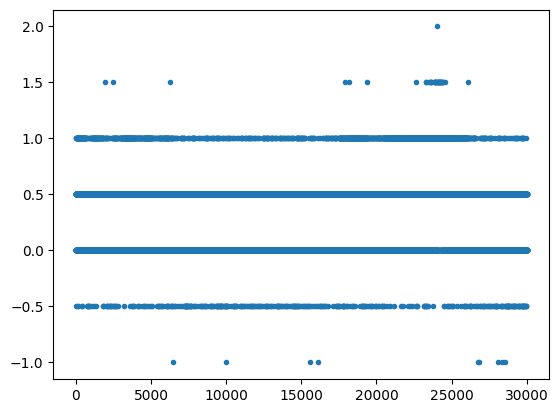

In [261]:
plt.scatter(call_0.index, call_0['mid_price'] - call_0['fair_value'], marker='.')

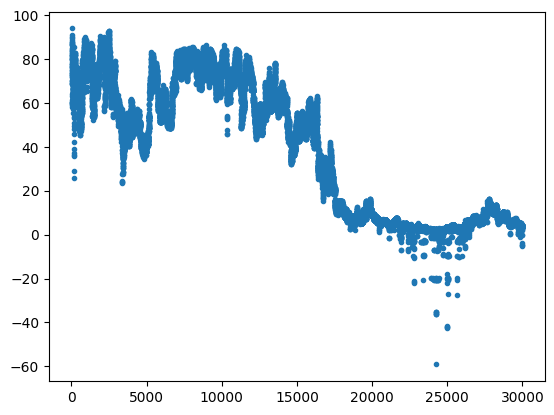

In [266]:
plt.scatter(call_4.index, call_4['mid_price'] - call_4['fair_value'], marker='.')

<Axes: >

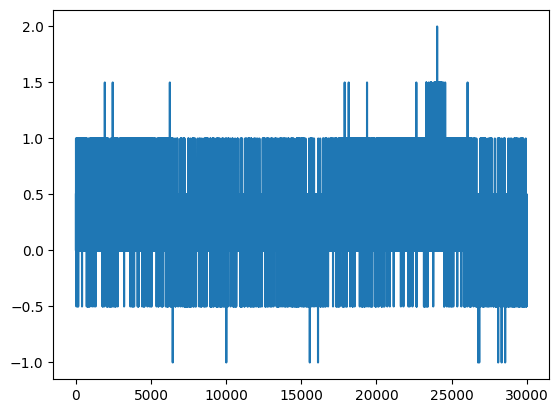

In [260]:
().plot()

In [113]:
products = [rock, call_0, call_1, call_2, call_3, call_4]

In [114]:
for prod in products:
    print(prod['bid_price_1'].isna().sum(), prod['ask_price_1'].isna().sum())

0 0
627 0
640 0
657 0
667 0
672 0


In [115]:
for prod in products:
    print(prod['mid_price'].isna().sum(), prod['mid_price'].isna().sum())

0 0
0 0
0 0
0 0
0 0
0 0


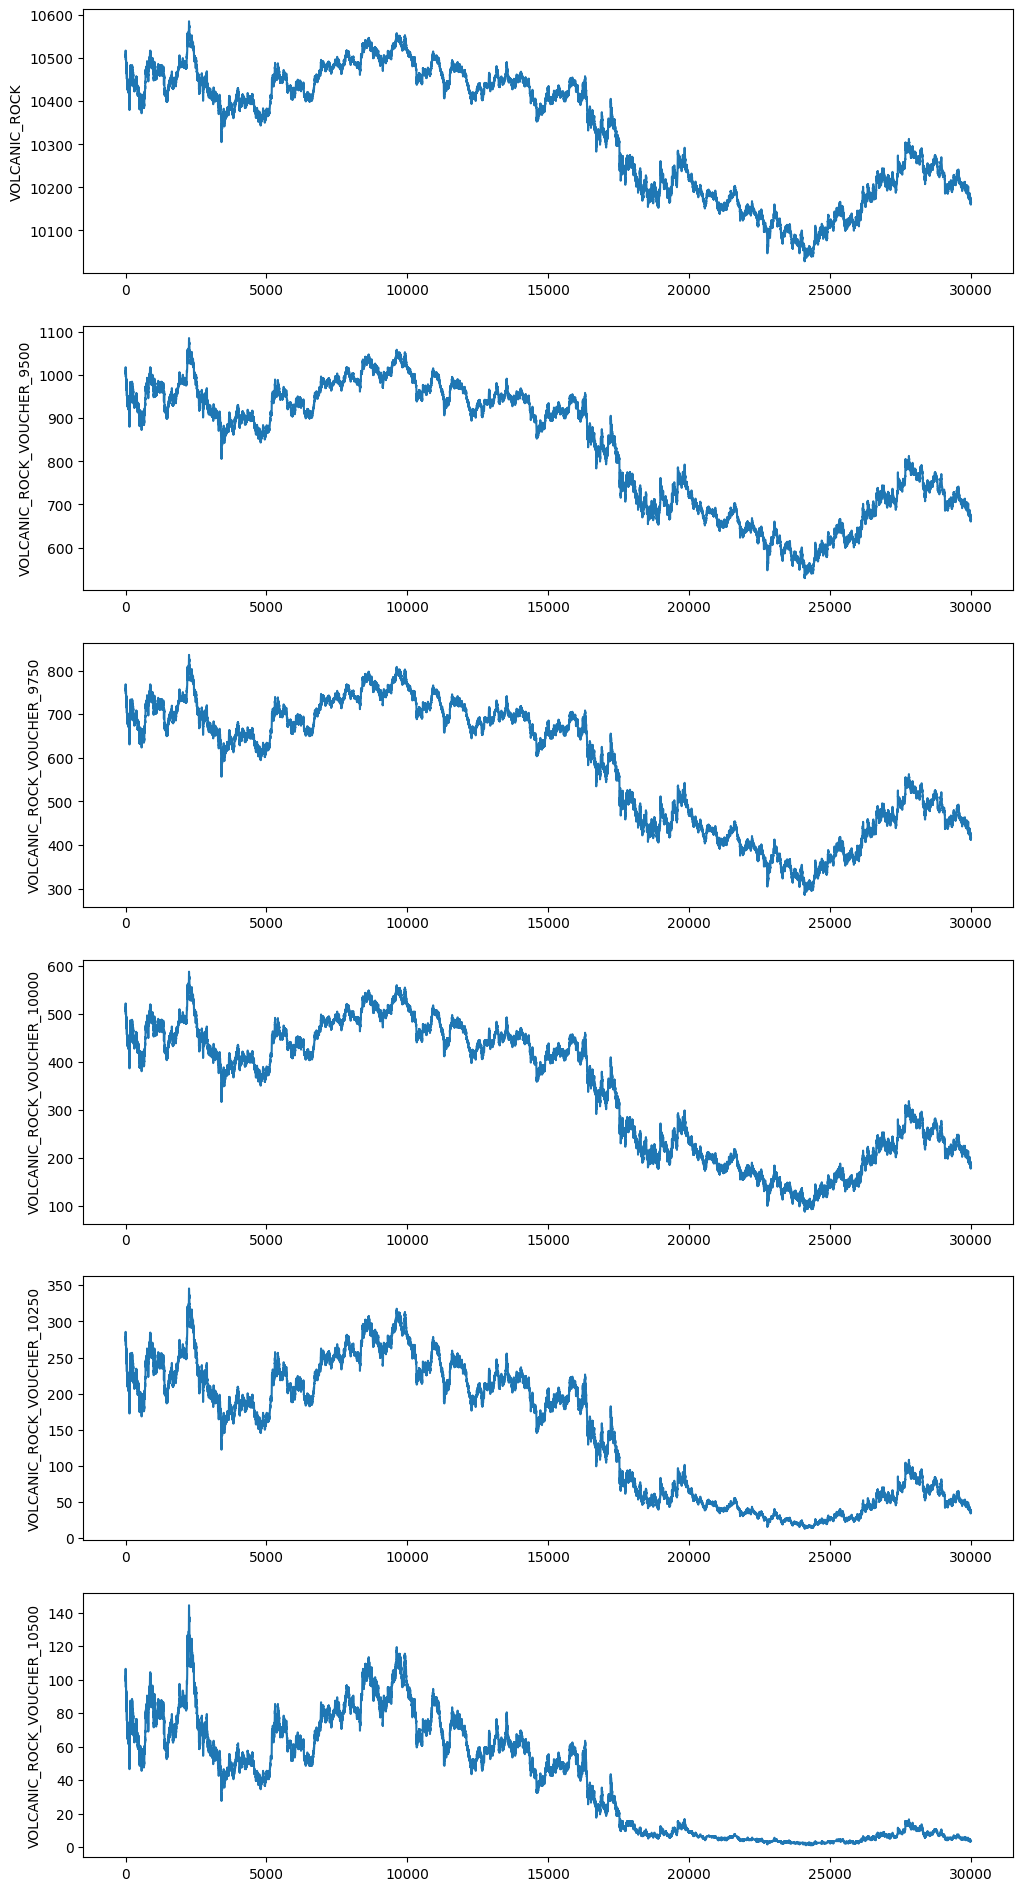

In [8]:
fig, ax = plt.subplots(6, 1, figsize=(12, 24))
for i, prod in enumerate(products):
    ax[i].plot(prod['mid_price'])
    ax[i].set_ylabel(prod['product'].iloc[0])
plt.show()

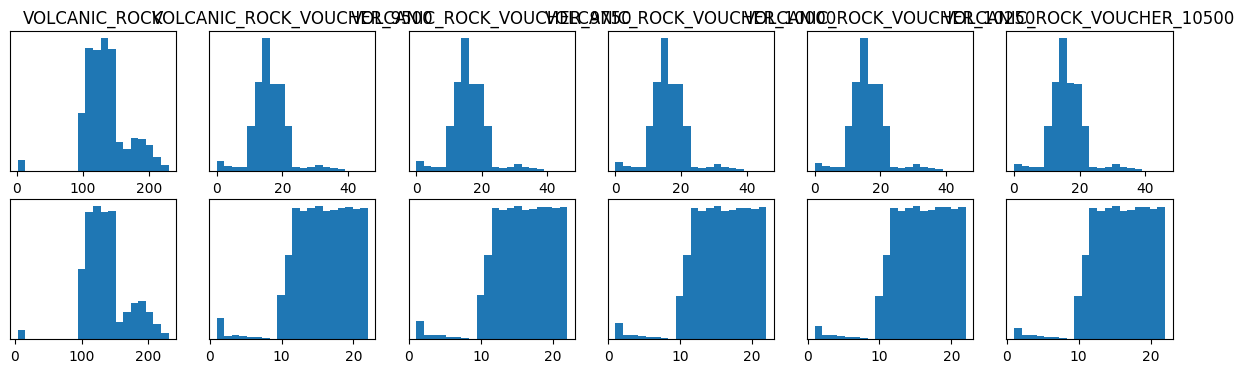

In [9]:
fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i, prod in enumerate(products):
    ax[0, i].hist(prod['bid_volume_1'], bins=20)
    ax[1, i].hist(prod['ask_volume_1'], bins=20)
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

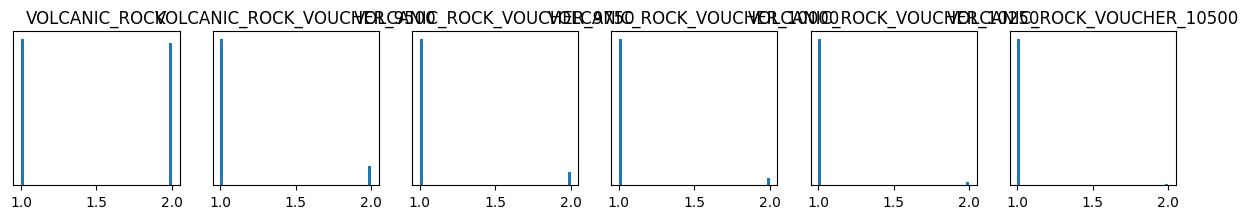

In [10]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i, prod in enumerate(products):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

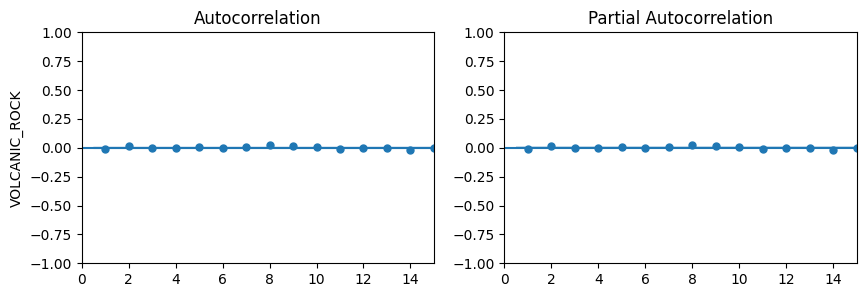

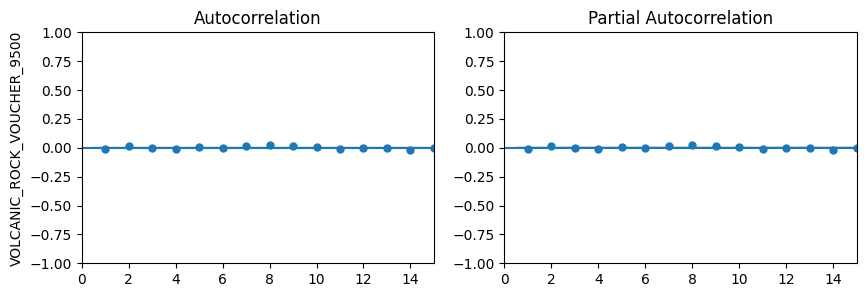

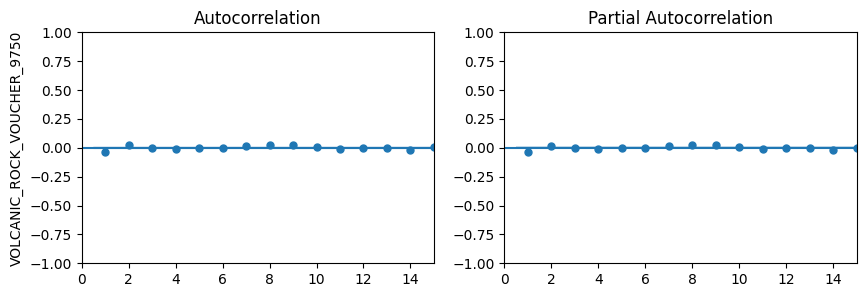

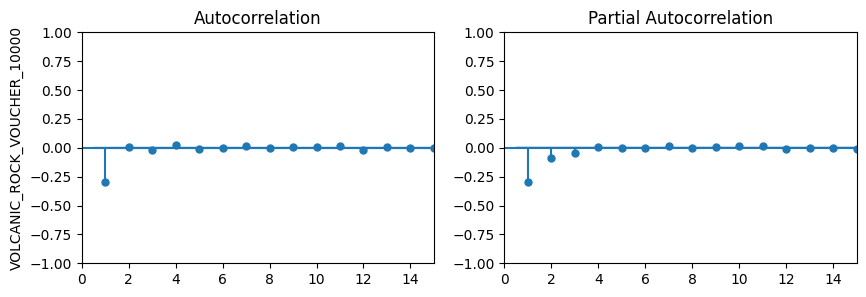

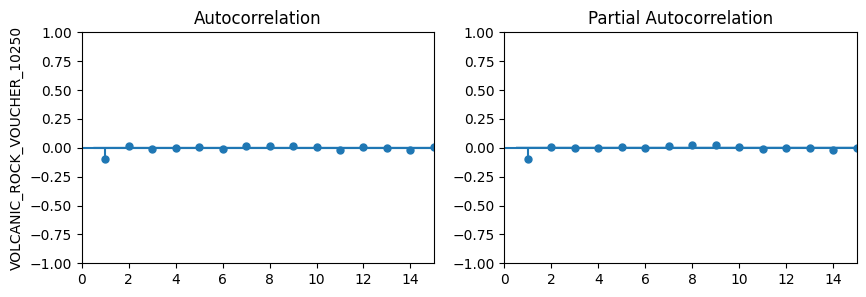

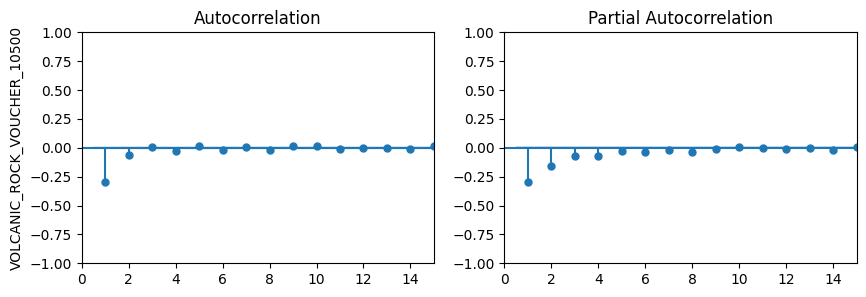

In [12]:
# for prod in products:
#     logr = np.log(prod['mid_price']) - np.log(prod['mid_price'].shift(1))
#     logr = logr.dropna()
#     fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#     plot_acf(logr, ax=ax[0], zero=False)
#     plot_pacf(logr, ax=ax[1], zero=False)
#     ax[0].set_xlim([0, 15])
#     ax[1].set_xlim([0, 15])
#     ax[0].set_ylabel(prod.iloc[0]['product'])
#     plt.show()

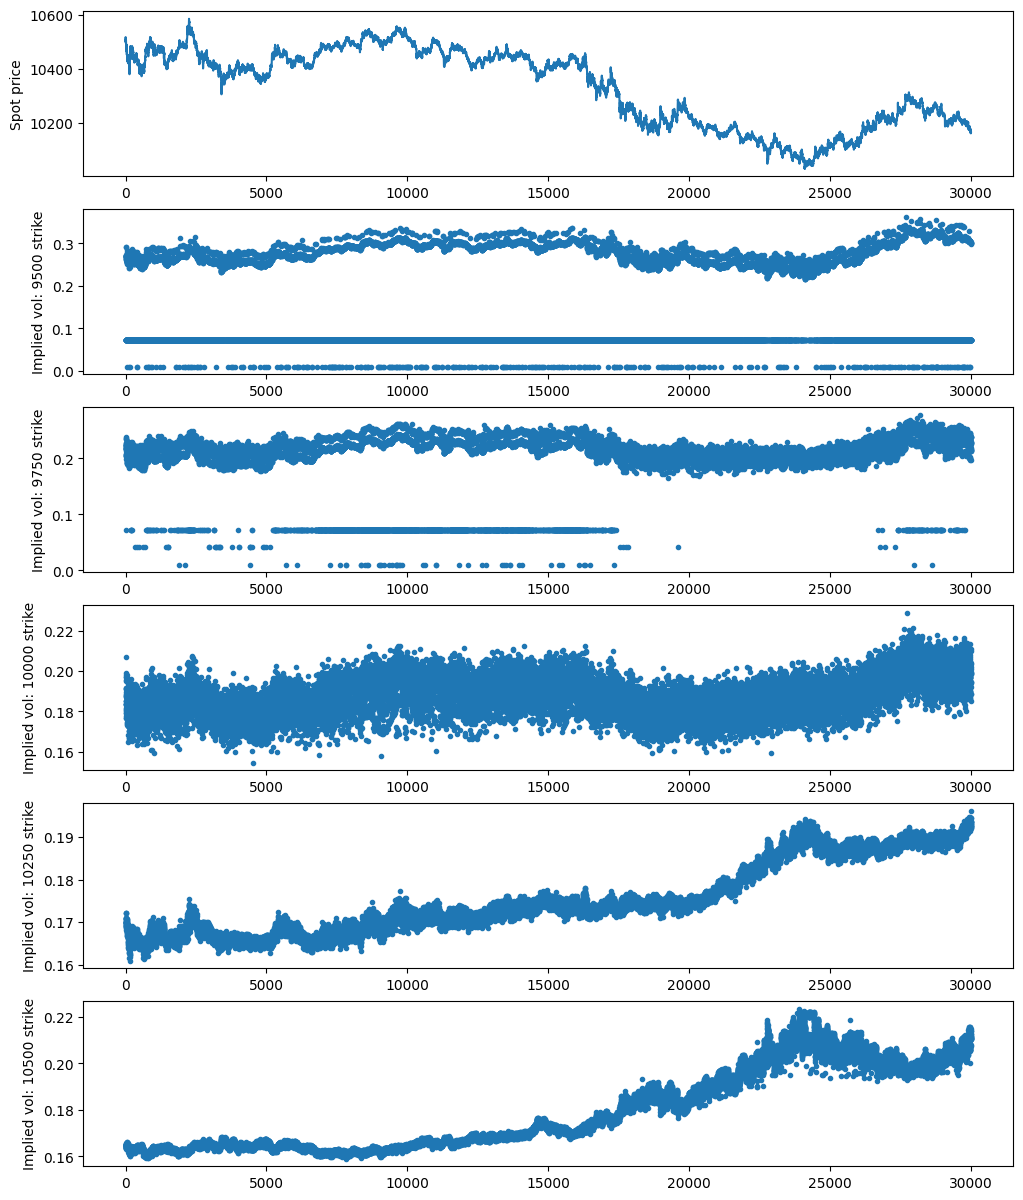

In [183]:
fig, ax = plt.subplots(6, 1, figsize=(12, 15))
ax[0].plot(rock['mid_price'])
ax[0].set_ylabel('Spot price')
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i + 1].scatter(np.arange(len(call)), call['implied_vol'], marker='.')
    ax[i + 1].set_ylabel(f'Implied vol: {call.iloc[0]['strike']} strike')
plt.show()

In [148]:
call_0[call_0['implied_vol'] <= 0.1]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,spot,strike,implied_vol
8,0,800,VOLCANIC_ROCK_VOUCHER_9500,997.0,10.0,NaN,NaN,NaN,NaN,998,10,NaN,NaN,NaN,NaN,997.5,0.0,10497.5,9500,0.071875
9,0,900,VOLCANIC_ROCK_VOUCHER_9500,995.0,22.0,NaN,NaN,NaN,NaN,996,22,NaN,NaN,NaN,NaN,995.5,0.0,10495.5,9500,0.071875
14,0,1400,VOLCANIC_ROCK_VOUCHER_9500,1009.0,17.0,NaN,NaN,NaN,NaN,1011,17,NaN,NaN,NaN,NaN,1010.0,0.0,10510.0,9500,0.071875
15,0,1500,VOLCANIC_ROCK_VOUCHER_9500,1004.0,20.0,NaN,NaN,NaN,NaN,1005,20,NaN,NaN,NaN,NaN,1004.5,0.0,10504.5,9500,0.071875
18,0,1800,VOLCANIC_ROCK_VOUCHER_9500,997.0,14.0,NaN,NaN,NaN,NaN,998,14,NaN,NaN,NaN,NaN,997.5,0.0,10497.5,9500,0.071875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,2,999100,VOLCANIC_ROCK_VOUCHER_9500,665.0,17.0,NaN,NaN,NaN,NaN,666,17,NaN,NaN,NaN,NaN,665.5,0.0,10165.5,9500,0.071875
29994,2,999400,VOLCANIC_ROCK_VOUCHER_9500,666.0,15.0,NaN,NaN,NaN,NaN,667,15,NaN,NaN,NaN,NaN,666.5,0.0,10166.5,9500,0.071875
29995,2,999500,VOLCANIC_ROCK_VOUCHER_9500,667.0,5.0,NaN,NaN,NaN,NaN,669,20,NaN,NaN,NaN,NaN,668.0,0.0,10168.0,9500,0.071875
29998,2,999800,VOLCANIC_ROCK_VOUCHER_9500,667.0,20.0,NaN,NaN,NaN,NaN,668,20,NaN,NaN,NaN,NaN,667.5,0.0,10167.5,9500,0.071875


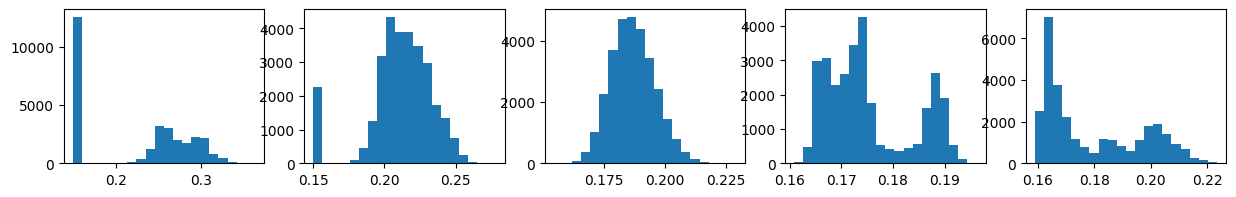

In [130]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, call in enumerate([call_0, call_1, call_2, call_3, call_4]):
    ax[i].hist(call['implied_vol'], bins=20)
plt.show()

In [192]:
call_0

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,spot,strike,implied_vol
0,0,0,VOLCANIC_ROCK_VOUCHER_9500,1003.0,19.0,NaN,NaN,NaN,NaN,1004,19,NaN,NaN,NaN,NaN,1003.5,0.0,10503.0,9500,0.269462
1,0,100,VOLCANIC_ROCK_VOUCHER_9500,1010.0,13.0,NaN,NaN,NaN,NaN,1011,13,NaN,NaN,NaN,NaN,1010.5,0.0,10510.0,9500,0.271054
2,0,200,VOLCANIC_ROCK_VOUCHER_9500,1013.0,15.0,NaN,NaN,NaN,NaN,1014,15,NaN,NaN,NaN,NaN,1013.5,0.0,10513.0,9500,0.271738
3,0,300,VOLCANIC_ROCK_VOUCHER_9500,1017.0,13.0,NaN,NaN,NaN,NaN,1019,13,NaN,NaN,NaN,NaN,1018.0,0.0,10517.5,9500,0.272761
4,0,400,VOLCANIC_ROCK_VOUCHER_9500,1009.0,15.0,NaN,NaN,NaN,NaN,1011,15,NaN,NaN,NaN,NaN,1010.0,0.0,10509.5,9500,0.270949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2,999500,VOLCANIC_ROCK_VOUCHER_9500,667.0,5.0,NaN,NaN,NaN,NaN,669,20,NaN,NaN,NaN,NaN,668.0,0.0,10168.0,9500,0.071875
29996,2,999600,VOLCANIC_ROCK_VOUCHER_9500,667.0,14.0,NaN,NaN,NaN,NaN,668,14,NaN,NaN,NaN,NaN,667.5,0.0,10167.0,9500,0.301131
29997,2,999700,VOLCANIC_ROCK_VOUCHER_9500,667.0,13.0,NaN,NaN,NaN,NaN,668,13,NaN,NaN,NaN,NaN,667.5,0.0,10167.0,9500,0.301139
29998,2,999800,VOLCANIC_ROCK_VOUCHER_9500,667.0,20.0,NaN,NaN,NaN,NaN,668,20,NaN,NaN,NaN,NaN,667.5,0.0,10167.5,9500,0.071875


In [217]:
rock

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK,10502.0,205.0,NaN,NaN,NaN,NaN,10504,146,10505.0,59.0,NaN,NaN,10503.0,0.0
1,0,100,VOLCANIC_ROCK,10509.0,192.0,NaN,NaN,NaN,NaN,10511,122,10512.0,70.0,NaN,NaN,10510.0,0.0
2,0,200,VOLCANIC_ROCK,10512.0,167.0,NaN,NaN,NaN,NaN,10514,109,10515.0,58.0,NaN,NaN,10513.0,0.0
3,0,300,VOLCANIC_ROCK,10517.0,118.0,10516.0,68.0,NaN,NaN,10518,118,10519.0,68.0,NaN,NaN,10517.5,0.0
4,0,400,VOLCANIC_ROCK,10509.0,128.0,10508.0,73.0,NaN,NaN,10510,128,10511.0,73.0,NaN,NaN,10509.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2,999500,VOLCANIC_ROCK,10167.0,110.0,10166.0,51.0,NaN,NaN,10169,156,NaN,NaN,NaN,NaN,10168.0,0.0
29996,2,999600,VOLCANIC_ROCK,10166.0,161.0,NaN,NaN,NaN,NaN,10168,101,10169.0,60.0,NaN,NaN,10167.0,0.0
29997,2,999700,VOLCANIC_ROCK,10166.0,143.0,10165.0,51.0,NaN,NaN,10168,194,NaN,NaN,NaN,NaN,10167.0,0.0
29998,2,999800,VOLCANIC_ROCK,10167.0,119.0,10166.0,57.0,NaN,NaN,10168,119,10169.0,57.0,NaN,NaN,10167.5,0.0


In [223]:
call_0.iloc[0]['mid_price'], call_0.iloc[0]['implied_vol']

(np.float64(1003.5), np.float64(0.2694616505644081))

In [230]:
call_0.shape

(30000, 20)

In [241]:
np.log(call_0['mid_price'] / call_0['mid_price'].shift(1)).rolling(10).std() * np.sqrt(10000)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
29995    0.522090
29996    0.454558
29997    0.437552
29998    0.398908
29999    0.390347
Name: mid_price, Length: 30000, dtype: float64

In [240]:
tte = 5 / 250
bs = BlackScholes(spot=10503, strike=9500, time_to_expiry=tte)
bs.call_price(0.324406)

1005.3184115382974